<a href="https://colab.research.google.com/github/AnDDoanf/phoBERT_projects/blob/master/phoBERT_tiki-books-rating-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/Kaggle"

In [ ]:
%cd /content/drive/MyDrive/Kaggle

/content/drive/MyDrive/Kaggle


In [ ]:
# !kaggle datasets download -d biminhc/tiki-books-dataset

In [ ]:
# !unzip tiki-books-dataset.zip -d tiki-books-dataset
# !rm *.zip

In [ ]:
!pip install tensorflow_addons
!pip install transformer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.7 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement transformer (from versions: none)
ERROR: No matching distribution found for transformer


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Data observation

In [ ]:
df = pd.read_csv('tiki-books-dataset/comments.csv')
df.head()

,product_id,comment_id,title,thank_count,customer_id,rating,content
0,74021317,12559756,Cực kì hài lòng,313,22051463,5,"Có những người bước đến, họ lấp đầy hạnh phúc ..."
1,74021317,16979365,Cực kì hài lòng,6,27791831,5,"Thấy nhiều bạn chê tiki gói hàng quá, may sao ..."
2,74021317,14069617,Cực kì hài lòng,25,17748750,5,"Bìa cực xinh, tiki giao hàng nhanh, sách không..."
3,74021317,8569824,Cực kì hài lòng,57,410797,5,"Sách lúc nhận hình thức rất ổn, không cong vên..."
4,74021317,18368714,Cực kì hài lòng,0,28545286,5,Một cuốn sách rất đáng đọc về tình yêu thương ...


## Training with phoBERT

### Data Pre-processing

In [ ]:
df = df[['rating', 'content']]
df = df.sample(n=1000)
df = df.dropna()

X = df.content.copy()
y = df.rating.copy()

y = tf.keras.utils.to_categorical(y)


### Training the model

In [ ]:
# Define training strategy
gpus = tf.config.experimental.list_logical_devices("GPU")
if len(gpus) == 1:
    strategy = tf.distribute.get_strategy()
else:
    strategy = tf.distribute.get_strategy()

from sklearn.model_selection import train_test_split
from transformers import TFAutoModel, AutoTokenizer
from tensorflow.keras import Input, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional, LSTM, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

MAX_LEN = 200
model_name = 'vinai/phobert-base'

# Tokenizing
tokenizer = AutoTokenizer.from_pretrained(model_name)
inputs = [tokenizer(item,
                    max_length = MAX_LEN,
                    padding = 'max_length',
                    truncation = True,
                    return_tensors = 'np')['input_ids'].reshape(MAX_LEN)
          for _, item in X.items()]

X_train, X_test, y_train, y_test = train_test_split(np.asarray(inputs),
                                                    y,
                                                    random_state=1905,
                                                    test_size=0.2,
                                                    shuffle=True)

# Build model
with strategy.scope():
    encoder = TFAutoModel.from_pretrained(model_name)

    input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32)

    embedding = encoder(input_ids)[1]

    x = Dense(128, activation = 'relu', kernel_regularizer = regularizers.L2(0.1))(embedding)
    x = Dropout(0.2)(x)

    x = Dense(y.shape[1],
              activation = 'softmax',
              kernel_initializer=tf.initializers.GlorotUniform(seed=1905),
              name='output_layer')(x)

    model = Model(inputs=[input_ids], outputs = x)

step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
    [500, 800], [1e0, 1e-1, 1e-3])

lr = 1e-2 * schedule(step)
wd = lambda: 1e-5 * schedule(step)

model.compile(
    optimizer=tfa.optimizers.AdamW(weight_decay=wd,
                                   learning_rate=lr),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])

# Train the model
history = model.fit(X_train,
                    y_train,
                    epochs = 20,
                    verbose = 1,
                    validation_split = 0.1,
                    batch_size = 32)

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/20
17/17 [==============================] - 41s 1s/step - loss: 12.2505 - accuracy: 0.5326 - val_loss: 6.8671 - val_accuracy: 0.7500
Epoch 2/20
17/17 [==============================] - 22s 1s/step - loss: 4.2918 - accuracy: 0.7281 - val_loss: 2.4134 - val_accuracy: 0.7500
Epoch 3/20
17/17 [==============================] - 22s 1s/step - loss: 1.8878 - accuracy: 0.7356 - val_loss: 1.5562 - val_accuracy: 0.7500
Epoch 4/20
17/17 [==============================] - 22s 1s/step - loss: 1.6242 - accuracy: 0.6778 - val_loss: 2.1779 - val_accuracy: 0.7500
Epoch 5/20
17/17 [==============================] - 22s 1s/step - loss: 1.5943 - accuracy: 0.7467 - val_loss: 1.4448 - val_accuracy: 0.7500
Epoch 6/20
17/17 [==============================] - 22s 1s/step - loss: 1.3326 - accuracy: 0.7616 - val_loss: 1.2787 - val_accuracy: 0.7500
Epoch 7/20
17/17 [==============================] - 22s 1s/step - loss: 1.4106 - accuracy: 0.6872 - val_loss: 1.3633 - val_accuracy: 0.7500
Epoch 8/20
17/17 [=

### Evaluating the fine-tuned model

Evaluate on test data
1/1 [==============================] - 2s 2s/step - loss: 1.0300 - accuracy: 0.7600
test loss, test acc: [1.0299830436706543, 0.7599999904632568]


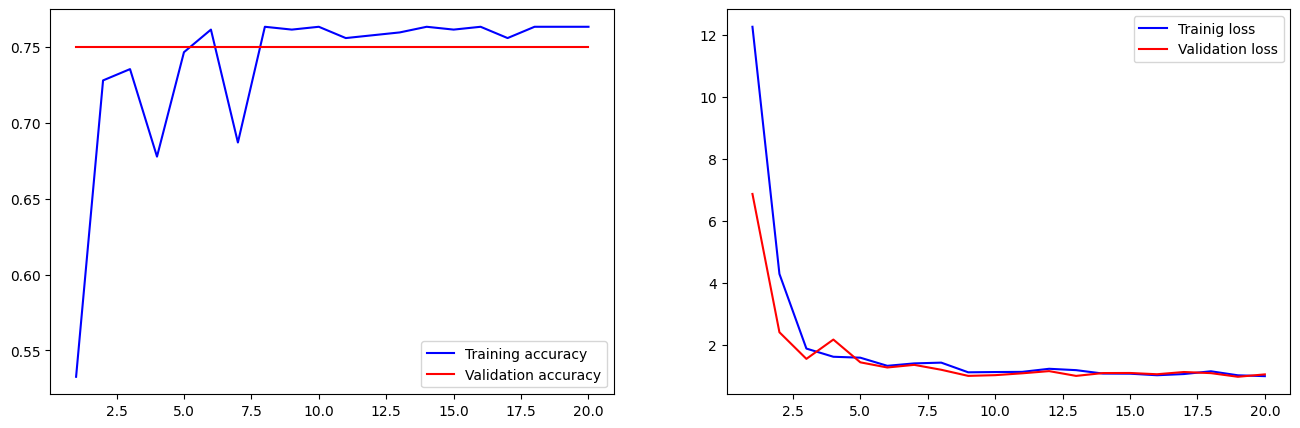

In [ ]:
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 5))
# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.legend()

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=256)
print("test loss, test acc:", results)

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label = 'Trainig loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.legend()

plt.show()

In [ ]:
# import pickle
# with open('phoBERT-tiki-books-ratings.pkl','wb') as f:
#     pickle.dump(model,f)

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)
